In [1]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
import lmfit
import numpy as np
import scipy.stats as ss
plt.style.use('neuron_color')
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols, rlm
import sys
sys.path.append('../')
from Linearity import Neuron
from pickle import dump

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Colorscheme for squares
color_sqr = { index+1: color for index, color in enumerate(matplotlib.cm.viridis(np.linspace(0,1,9)))}

In [3]:
prefix = '/home/bhalla/Documents/Codes/data'
currentClampFiles = prefix + '/media/sahil/NCBS_Shares_BGStim/patch_data/current_clamp_files_with_GABAzine.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [6]:
neurons = {}
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = prefix + dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    if n:
        neurons[str(n.date) + '_' + str(n.index)] = n

In [7]:
control_result2_rsquared_adj = []
control_result1_rsquared_adj = []
control_var_expected = []
gabazine_result2_rsquared_adj = []
gabazine_result1_rsquared_adj = []
gabazine_var_expected = []
tolerance = 5e-4

In [8]:
def simpleaxis(axes, every=False, outward=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if (outward):
            ax.spines['bottom'].set_position(('outward', 10))
            ax.spines['left'].set_position(('outward', 10))
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [9]:
def linearModel(x, beta=1):
    # Linear model
    return (beta*x)

def DN_model(x, beta=1, gamma=100):
    # Divisive normalization model
    #return x - a*(x**2)/(b+x)
    #return ((x**2)*(1-beta) + (gamma*x))/(x+gamma)
    return (gamma*x)/(x+gamma)

In [10]:
lin_aic = []
dn_aic = []
lin_chi = []
dn_chi = []

control_observed = {}
control_observed_average = {}
gabazine_observed ={}
gabazine_observed_average = {}
control_expected = {}
control_expected_average = {}
gabazine_expected ={}
gabazine_expected_average = {}
feature = 0

neuron = neurons['161013_c1']
# neuron = neurons['170303_c1']

## 5 A (GABAzine treatment abolishes divisive normalization)

In [11]:
feature = 0
expected, observed, g_expected, g_observed = {}, {}, {}, {}
for expType, exp in neuron:
    ## Control case
    if expType == "Control":
        for sqr in exp:
                if sqr > 1:
                    expected[sqr] = []
                    observed[sqr] = []
                    for coord in exp[sqr].coordwise:
                        for trial in exp[sqr].coordwise[coord].trials:
                            if all([value == 0 for value in trial.flags.values()]):
                                expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                                observed[sqr].append(trial.feature[feature])
    ## Gabazine case
    if(expType == "GABAzine"):
        for sqr in exp:
            if sqr > 1:
                g_expected[sqr] = []
                g_observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            g_expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                            g_observed[sqr].append(trial.feature[feature])

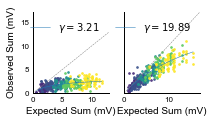

In [12]:
f, ax = plt.subplots(1,2, sharey=True)

## Control stuff
squareVal = []
list_control_expected = []
list_control_observed = []

max_exp, max_g_exp = 0.,0.
for sqr in sorted(observed):
    squareVal.append(ax[0].scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8, s=3))
    max_exp = max(max_exp, max(expected[sqr]))
    list_control_expected += expected[sqr]
    list_control_observed += observed[sqr]
    
X = np.array(list_control_expected)
y = np.array(list_control_observed)
idx   = np.argsort(X)
X = X[idx]
y = y[idx]

linear_Model = lmfit.Model(linearModel)
DN_Model = lmfit.Model(DN_model)

lin_pars = linear_Model.make_params()
lin_result = linear_Model.fit(y, lin_pars, x=X)
lin_aic.append(lin_result.aic)
lin_chi.append(lin_result.redchi)

DN_pars = DN_Model.make_params()
DN_result = DN_Model.fit(y, DN_pars, x=X)
dn_aic.append(DN_result.aic)
dn_chi.append(DN_result.redchi)

# print (lin_result.fit_report())
# print (DN_result.fit_report())

ax[0].set_xlim(xmin=0.)
ax[0].set_ylim(ymin=0.)
ax[0].set_xlabel("Expected")
ax[0].set_ylabel("Observed")
ax[0].set_title("Divisive Normalization fits")
div_norm = ax[0].plot(X, DN_result.best_fit, '-')


max_exp *=1.1
max_g_exp *=1.1
ax[0].set_xlim(0,max_exp)
ax[0].set_ylim(0,max_exp)
ax[0].set_xlabel("Expected Sum (mV)")
ax[0].set_ylabel("Observed Sum (mV)")
linear = ax[0].plot((0,max_exp), (0,max_exp), '--', c='gray')

legends = div_norm
#labels = [ "$\\beta={:.2f}$ \n $ \\gamma={:.2f}$".format(DN_result.params['beta'].value, DN_result.params['gamma'].value)]
labels = [ "$ \\gamma={:.2f}$".format(DN_result.params['gamma'].value)]
ax[0].legend(legends, labels)


### GABAzine stuff 
squareVal = []
list_gabazine_expected = []
list_gabazine_observed = []

max_exp, max_g_exp = 0.,0.
for sqr in sorted(g_observed):
    squareVal.append(ax[1].scatter(g_expected[sqr], g_observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8, s=3))
    max_exp = max(max_exp, max(g_expected[sqr]))
    list_gabazine_expected += g_expected[sqr]
    list_gabazine_observed += g_observed[sqr]
    
X = np.array(list_gabazine_expected)
y = np.array(list_gabazine_observed)
idx   = np.argsort(X)
X = X[idx]
y = y[idx]

linear_Model = lmfit.Model(linearModel)
DN_Model = lmfit.Model(DN_model)

lin_pars = linear_Model.make_params()
lin_result = linear_Model.fit(y, lin_pars, x=X)
lin_aic.append(lin_result.aic)
lin_chi.append(lin_result.redchi)

DN_pars = DN_Model.make_params()
DN_result = DN_Model.fit(y, DN_pars, x=X)
dn_aic.append(DN_result.aic)
dn_chi.append(DN_result.redchi)

# print (lin_result.fit_report())
# print (DN_result.fit_report())

ax[1].set_xlim(xmin=0.)
ax[1].set_ylim(ymin=0.)
ax[1].set_title("Divisive Normalization fits")
div_norm = ax[1].plot(X, DN_result.best_fit, '-')


max_exp *=1.1
max_g_exp *=1.1
ax[1].set_xlim(0,max_exp)
ax[1].set_ylim(0,max_exp)
ax[1].set_xlabel("Expected Sum (mV)")
# ax[1].set_ylabel("Observed Sum (mV)")
linear = ax[1].plot((0,max_exp), (0,max_exp), '--', c='gray')

legends = div_norm
#labels = [ "$\\beta={:.2f}$ \n $\\gamma={:.2f}$".format(DN_result.params['beta'].value, DN_result.params['gamma'].value)]
labels = [ "$\\gamma={:.2f}$".format(DN_result.params['gamma'].value)]
ax[1].legend(legends, labels)
ax[1].yaxis.set_visible(False)
simpleaxis(ax)
f.set_figwidth(3)
f.set_figheight(1.5)
dump(f,file('figures/fig5/5a.pkl','wb'))
plt.show()

## 5 C Gabazine - Control responses are still balanced

In [13]:
feature = 0
#expected, observed, g_expected, g_observed = {}, {}, {}, {}
control, gabazine = {}, {}
for expType, exp in neuron:
    ## Control case
    if(expType == "Control"):
        for sqr in exp:
            if sqr > 1:
                expected[sqr] = []
                observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    if all([value == 0 for value in exp[sqr].coordwise[coord].flags.values()]):
                        control[sqr] = exp[sqr]
    ## Gabazine case
    if(expType == "GABAzine"):
        for sqr in exp:
            if sqr > 1:
                g_expected[sqr] = []
                g_observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    if all([value == 0 for value in exp[sqr].coordwise[coord].flags.values()]):
                        gabazine[sqr] = exp[sqr]

derived_inh, exc = {}, {}
for sq in set(control).intersection(set(gabazine)):
    derived_inh[sq] = []
    exc[sq] = []
    for coord in set(control[sq].coordwise).intersection(set(gabazine[sq].coordwise)):
        derived_inh[sq].append(gabazine[sq].coordwise[coord].average_feature[feature] - control[sq].coordwise[coord].average_feature[feature])
        exc[sq].append(gabazine[sq].coordwise[coord].average_feature[feature])

0.8109933088525123 0.9247808925867301 -1.0556059936244653
1.3016210887338386
(array([0, 1, 2, 3, 4, 5, 6]),)


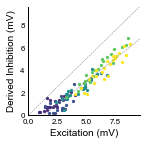

In [16]:
### Derived Inh
squareVal = []
list_exc = []
list_inh = []
f, ax = plt.subplots()
max_exp, max_g_exp = 0.,0.
for sqr in sorted(derived_inh):
    squareVal.append(ax.scatter(exc[sqr], derived_inh[sqr], label=str(sqr), c=color_sqr[sqr], s=5))
    max_exp = max(max_exp, max(exc[sqr]))
    list_exc += exc[sqr]
    list_inh += derived_inh[sqr]
    
max_exp *=1.1
max_g_exp *=1.1
ax.set_xlim(0,max_exp)
ax.set_ylim(0,max_exp)
ax.set_xlabel("Excitation (mV)")
ax.set_ylabel("Derived Inhibition (mV)")
linear = ax.plot((0,max_exp), (0,max_exp), '--', c='gray')

legends = squareVal + linear
labels = sorted(observed.keys()) + [ "Linear sum"]

slope, intercept, rval, pval, stderr = ss.linregress(list_exc, list_inh)
x_ = np.linspace(0,max_exp)
y_ = (slope*x_) + intercept
ax.plot(x_,y_, '--', color='gray')
print (slope, rval**2, intercept)
x_intercept = -intercept/slope
print (x_intercept)
# ax.legend(legends, labels)
f.set_figwidth(2)
f.set_figheight(2)
simpleaxis(ax)
plt.show()

In [13]:
def getAvgTrace(neuron, expType="Control"):
    ''' Returns Expected, Observed, Time, Squares for the experiment'''
    if expType in neuron.experiment:
        exp = neuron.experiment[expType]
        avgTrace = {}
        for sqr in exp:
            for coord in exp[sqr].coordwise:
                    trace = []
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            trace.append(trial.interestWindow)
                    if len(trace)>2:
                        averagedTrace = np.mean(trace,axis=0)
                        avgTrace[coord] = averagedTrace
        return avgTrace

c4 160928
[]
-0.34311697471801167 0.05962204280192744 -11.680702260656549


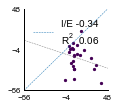

c4 160817
c1 161117
[]
1.6345832125093152 0.8487774366301593 -28.249907912380635


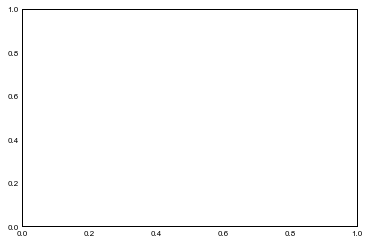

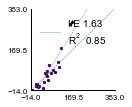

c2 170222
[]
1.0564771157093726 0.7051117648605847 -37.23168096698001


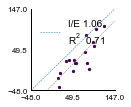

c1 161228
[]
1.084542423772472 0.9502085022089375 -21.009572817273977


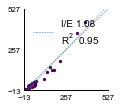

c1 160830
c3 161027
[]
0.8959012613977904 0.900129938784994 -76.7741490945287


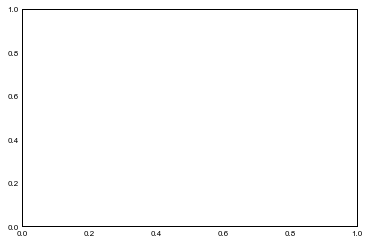

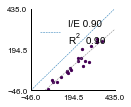

c1 160920
[]
0.26759283978957266 0.16553520873240554 -16.97555735646869


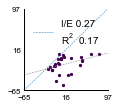

c1 161013
[]
0.5400422989738697 0.6017895939102209 -12.131240359907135


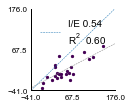

c5 160927
[]
0.7253269671463595 0.7680403034413031 -25.106430581868167


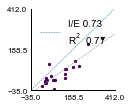

c1 170303
[]
0.7880258448838637 0.7057993039967495 -10.399248142529842


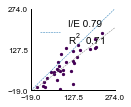

In [19]:
slopeArr, r_sqArr = [], []
for index in neurons:
#     print (index)
    neuron = neurons[index]
    print(neuron.index, neuron.date)
    fig, ax = plt.subplots()
    control = getAvgTrace(neuron)
    gabazine = getAvgTrace(neuron, "GABAzine")
    feature = 1
    if control and gabazine:
        list_exc, list_inh, sqrArr = [], [], []
        for coord in set(control.keys()) & set(gabazine.keys()):
            if (len(coord)) == 1: # One square only
                if feature == 0:# and np.max(gabazine[coord]) < 2.:
                    exc_max = np.max(gabazine[coord])
                    inh_max = np.max(gabazine[coord] - control[coord])    
                elif feature == 1:# and np.max(gabazine[coord]) < 2.:
                    exc_max = np.trapz(gabazine[coord])*0.05
                    inh_max = np.trapz(gabazine[coord] - control[coord])*0.05
                list_exc.append(exc_max)
                list_inh.append(inh_max)
                ax.scatter(exc_max, inh_max, c=color_sqr[len(coord)],s=5)
                
        if list_exc and list_inh:
            min_exc_inh, max_exc_inh =  1.2*np.min([list_exc, list_inh]), 1.2*np.max([list_exc, list_inh])
            #squareVal.append(ax.scatter(exc[sqr], derived_inh[sqr]))
            print(sqrArr)
            slope, intercept, rval, pval, stderr = ss.linregress(list_exc, list_inh)
            x_ = np.linspace(min_exc_inh, max_exc_inh,1000)
            y_ = (slope*x_) + intercept
            ax.plot(x_,y_, '--', color='gray')
            print (slope, rval**2, intercept)

            ax.set_xlim(min_exc_inh, max_exc_inh)
            ax.set_ylim(min_exc_inh, max_exc_inh)
            
            ax.set_xticks( np.linspace(np.round(min_exc_inh), np.round(max_exc_inh),3) )
            ax.set_yticks( np.linspace(np.round(min_exc_inh), np.round(max_exc_inh),3) )
            
            ax.plot([min_exc_inh, max_exc_inh], [min_exc_inh, max_exc_inh], '--', label="I/E {:.2f}\n".format(slope) + "$\mathregular{R^2}$ " + " {:.2f}".format(rval**2))
            
#             ax.set_xlabel("Exc (mV.ms)")
#             ax.set_ylabel("Inh (mV.ms)")
            fig.set_figwidth(1.5)
            fig.set_figheight(1.5)
            ax.legend(loc='upper left')
            simpleaxis(ax)
            dump(fig,file('figures/supplementary/oneSq_bal_{}_{}.pkl'.format(neuron.index, neuron.date),'wb'))
            plt.show()

            slopeArr.append(slope)
            r_sqArr.append(rval**2)        

### One square data also shows balance

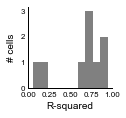

In [20]:
fig, ax = plt.subplots()
ax.hist(r_sqArr, color='gray')
simpleaxis(ax)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xlabel("R-squared")
ax.set_ylabel("# cells")
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
dump(fig,file('figures/supplementary/oneSqBalanceHist.pkl','wb'))
plt.show()

[]
Slope = 0.971020045038, r^2 = 0.930839306184, y-intercept= -3.6501154086e-05, x-intercept= 3.75905258316e-05
(array([  3,  47,  59,  61,  73,  93,  99, 106, 139]),)


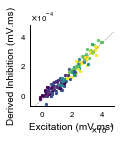

In [18]:
neuron = neurons['161013_c1']
scalingFactor = 1e-3
windowsize = 100
fig, ax = plt.subplots()
control = getAvgTrace(neuron)
gabazine = getAvgTrace(neuron, "GABAzine")
if control and gabazine:
    list_exc, list_inh, sqrArr = [], [], []
    for coord in set(control.keys()) & set(gabazine.keys()):
        exc_max = np.trapz(gabazine[coord],dx=50e-6*scalingFactor)
        inh_max = np.trapz(gabazine[coord] - control[coord],dx=50e-6*scalingFactor)
        list_exc.append(exc_max)
        list_inh.append(inh_max)
        ax.scatter(exc_max, inh_max, c=color_sqr[len(coord)],s=5)
    if len(list_exc) and len(list_inh):
        min_exc_inh, max_exc_inh =  1.2*np.min([list_exc, list_inh]), 1.2*np.max([list_exc, list_inh])
        #squareVal.append(ax.scatter(exc[sqr], derived_inh[sqr]))
        print(sqrArr)
        slope, intercept, rval, pval, stderr = ss.linregress(list_exc, list_inh)
        x_ = np.linspace(min_exc_inh, max_exc_inh,1000)
        y_ = (slope*x_) + intercept
        ax.plot(x_,y_, '--', color='gray')
        x_intercept = -intercept/slope
        print ("Slope = {}, r^2 = {}, y-intercept= {}, x-intercept= {}".format(slope, rval**2, intercept, x_intercept))
        print(np.where( (np.array(list_inh) < 0) & (np.array(list_exc) > 0) ))
        ax.set_xlim(min_exc_inh, max_exc_inh)
        ax.set_ylim(min_exc_inh, max_exc_inh)
        ax.set_xticks([0,2e-4,4e-4])
        ax.set_yticks([0,2e-4,4e-4])
        ax.set_xlabel("Excitation (mV.ms)")
        ax.set_ylabel("Derived Inhibition (mV.ms)")
        ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
        ax.xaxis.major.formatter._useMathText = True
        ax.yaxis.major.formatter._useMathText = True
        
        fig.set_figwidth(1.5)
        fig.set_figheight(1.5)
        simpleaxis(ax)
        dump(fig,file('figures/fig5/5d.pkl','wb'))
        plt.show()

In [19]:
array([  3,  47,  59,  61,  73,  93,  99, 106, 139]),

NameError: name 'array' is not defined

In [16]:
neurons

{'160817_c4': <Linearity.Neuron instance at 0x7f77963bea70>,
 '160830_c1': <Linearity.Neuron instance at 0x7f77963beb90>,
 '160920_c1': <Linearity.Neuron instance at 0x7f77dfd2e4d0>,
 '160927_c5': <Linearity.Neuron instance at 0x7f77959e57a0>,
 '160928_c4': <Linearity.Neuron instance at 0x7f7796224ef0>,
 '161013_c1': <Linearity.Neuron instance at 0x7f7796239cf8>,
 '161027_c3': <Linearity.Neuron instance at 0x7f7795b954d0>,
 '161117_c1': <Linearity.Neuron instance at 0x7f7795edac68>,
 '161228_c1': <Linearity.Neuron instance at 0x7f77960f7c20>,
 '170222_c2': <Linearity.Neuron instance at 0x7f7795794908>,
 '170303_c1': <Linearity.Neuron instance at 0x7f77963a0b48>}

## Population slopes

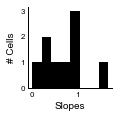

Median slope is 0.7


In [103]:
bins = 8
fig, ax = plt.subplots()
ax.hist(slopeArr,bins=bins,color='k')
ax.set_xlabel("Slopes")
ax.set_ylabel("# Cells")
simpleaxis(ax)
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
dump(fig,file('figures/fig5/5e.pkl','wb'))
plt.show()
print ("Median slope is {:.1f}".format(np.median(slopeArr)))

## Population r-squared

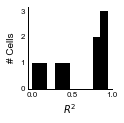

Median $r^2$ is 0.8


In [104]:
fig, ax = plt.subplots()
ax.hist(r_sqArr,color='k')
ax.set_xlabel("$R^2$")
ax.set_ylabel("# Cells")
simpleaxis(ax)
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
dump(fig,file('figures/fig5/5f.pkl','wb'))
plt.show()
print ("Median $r^2$ is {:.1f}".format(np.median(r_sqArr)))

## 5 D (Comparing Gabazine and Control DN fit parameters) : 2 neurons have an nans. Check what's happening

In [55]:
neurons.pop('161027_c3', None)
# neurons.pop('160817_c4', None)
neurons.pop('160927_c5', None)

<Linearity.Neuron instance at 0x7f77959e57a0>

In [56]:
feature = 0
DN_Control = []
DN_GABAzine = []

for index in neurons:
    neuron = neurons[index]
    if set(["Control", "GABAzine"]) <= set(neuron.experiment.keys()):
        if (len(neuron.experiment["Control"]) > 1 and len(neuron.experiment["GABAzine"]) > 1):
            print (neuron.date + '-' + neuron.index)
            expected, observed, g_expected, g_observed = {}, {}, {}, {}
            for expType, exp in neuron:
                ## Control case
                if expType == "Control":
                    for sqr in exp:
                            if sqr > 1:
                                expected[sqr] = []
                                observed[sqr] = []
                                for coord in exp[sqr].coordwise:
                                    for trial in exp[sqr].coordwise[coord].trials:
                                        if all([value == 0 for value in trial.flags.values()]):
                                            expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                                            observed[sqr].append(trial.feature[feature])

                ## Gabazine case
                if(expType == "GABAzine"):
                    for sqr in exp:
                        if sqr > 1:
                            g_expected[sqr] = []
                            g_observed[sqr] = []
                            for coord in exp[sqr].coordwise:
                                for trial in exp[sqr].coordwise[coord].trials:
                                    if all([value == 0 for value in trial.flags.values()]):
                                        g_expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                                        g_observed[sqr].append(trial.feature[feature])

            ## Control stuff
            squareVal = []
            list_control_expected = []
            list_control_observed = []

            max_exp, max_g_exp = 0.,0.
            for sqr in sorted(observed):
                list_control_expected += expected[sqr]
                list_control_observed += observed[sqr]

            X = np.array(list_control_expected)
            y = np.array(list_control_observed)
            idx   = np.argsort(X)
            X = X[idx]
            y = y[idx]

            DN_Model = lmfit.Model(DN_model)
            DN_pars = DN_Model.make_params()
            
            DN_result = DN_Model.fit(y, DN_pars, x=X)
            DN_Control.append((DN_result.params['beta'], DN_result.params['gamma'], DN_result.redchi))

            ### GABAzine stuff 
            squareVal = []
            list_gabazine_expected = []
            list_gabazine_observed = []

            del DN_Model

            max_exp, max_g_exp = 0.,0.
            for sqr in sorted(g_observed):
                list_gabazine_expected += g_expected[sqr]
                list_gabazine_observed += g_observed[sqr]

            X = np.array(list_gabazine_expected)
            y = np.array(list_gabazine_observed)
            idx   = np.argsort(X)
            X = X[idx]
            y = y[idx]

            DN_Model = lmfit.Model(DN_model)
            DN_pars = DN_Model.make_params()
            DN_result = DN_Model.fit(y, DN_pars, x=X)
            DN_GABAzine.append((DN_result.params['beta'], DN_result.params['gamma'],DN_result.redchi))

160928-c4
161117-c1
170222-c2
161228-c1
160830-c1
160920-c1
161013-c1
170303-c1


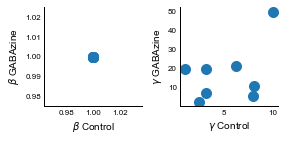

In [58]:
fig, ax = plt.subplots(1, 2)
dn_beta, dn_gamma, dn_chi = map(list, zip(*DN_Control))
gaba_beta, gaba_gamma, gaba_chi = map(list, zip(*DN_GABAzine))
ax[0].scatter(dn_beta, gaba_beta)
ax[1].scatter(dn_gamma, gaba_gamma)

# ax.plot([0,3],[0,3],'--')
# ax.set_xlim(0,3)
# ax.set_ylim(0,3)
ax[0].set_xlabel("$\\beta$ Control")
ax[0].set_ylabel("$\\beta$ GABAzine")
ax[1].set_xlabel("$\\gamma$ Control")
ax[1].set_ylabel("$\\gamma$ GABAzine")
simpleaxis(ax)
fig.set_figwidth(4)
fig.set_figheight(2)
fig.tight_layout()
plt.show()

In [59]:
dn_beta, gaba_beta

([<Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>],
 [<Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>,
  <Parameter 'beta', value=1.0 +/- 0, bounds=[-inf:inf]>])

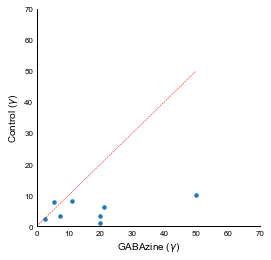

In [60]:
fig, ax = plt.subplots()
ax.scatter(gaba_gamma,  dn_gamma, s=12)
ax.plot([0,50],[0,50],'r--')
ax.set_xlabel("GABAzine ($\\gamma$)")
ax.set_ylabel("Control ($\\gamma$)")
ax.set_xlim(0,70)
ax.set_ylim(0,70)
#ax.set_xlim(0,0.6)
#ax.set_ylim(0,0.6)

simpleaxis(ax)
fig.set_figheight(4)
fig.set_figwidth(4)
plt.show()

In [61]:
dn_gamma

[<Parameter 'gamma', value=2.4902598233584792 +/- 0, bounds=[-inf:inf]>,
 <Parameter 'gamma', value=1.0532294368411848 +/- 0, bounds=[-inf:inf]>,
 <Parameter 'gamma', value=6.3245459279086838 +/- 0, bounds=[-inf:inf]>,
 <Parameter 'gamma', value=10.082497562604928 +/- 0, bounds=[-inf:inf]>,
 <Parameter 'gamma', value=3.2191561517302252 +/- 0, bounds=[-inf:inf]>,
 <Parameter 'gamma', value=7.9794350965374177 +/- 0, bounds=[-inf:inf]>,
 <Parameter 'gamma', value=3.2147359871464545 +/- 0, bounds=[-inf:inf]>,
 <Parameter 'gamma', value=8.1623936008806872 +/- 0, bounds=[-inf:inf]>]

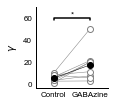

In [93]:
indices = [1,2]
fig, ax = plt.subplots()

for ind, (l,d) in enumerate(zip(gaba_gamma, dn_gamma)):
    ax.plot(indices, [d,l], 'o-', alpha=1, color='0.5', markerfacecolor='white',markersize=6)
ax.plot(indices, [np.average(dn_gamma), np.average(gaba_gamma)],'o-', alpha=1., color='0',markersize=6)
ax.set_xlim((0.5,2.5))
ax.set_ylim(ymin=-4,ymax=70)
ax.set_ylabel("$\\gamma$")
ax.set_xticks(indices)
ax.set_xticklabels(('Control','GABAzine'))
y, h, col = np.max([np.max(gaba_gamma),np.max(dn_gamma)])+ 8 , 2, 'k'
plt.plot([1,1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((1+2)*.5, y+h, "*", ha='center', va='bottom', color=col)

simpleaxis(ax)
fig.set_figwidth(1.3)
fig.set_figheight(1.5)
dump(fig,file('figures/fig5/5c.pkl','wb'))
plt.show()

In [95]:
print(ss.ranksums(dn_gamma,gaba_gamma))
print ("N is {}".format(len(dn_gamma)))

RanksumsResult(statistic=-1.9953991197399139, pvalue=0.045999366875037084)
N is 8


In [63]:
# f, ax = plt.subplots()
# bins = np.linspace(0,1,15)
# ax.hist(DN_Control,bins=bins,color='b')
# ax.hist(DN_GABAzine,bins=bins,color='g')
# plt.show()

In [64]:
##  Stuff I'm not using.

In [ ]:
# fig, ax = plt.subplots()
# dn_beta, dn_gamma, gaba_beta, gaba_gamma = np.array(dn_beta), np.array(dn_gamma), np.array(gaba_beta), np.array(gaba_gamma)
# ax.scatter(1./dn_beta, dn_gamma/dn_beta, c='b', label="Control")
# ax.scatter(1./gaba_beta, gaba_gamma/gaba_beta, c='orange', label="GABAzine")
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.set_xlim(0,20)
# # ax.set_ylim(0,20)
# ax.set_xlabel("$1/\\beta$")
# ax.set_ylabel("$\\gamma/\\beta$")
# simpleaxis(ax)
# fig.set_figheight(2)
# fig.set_figwidth(2)
# ax.legend(loc='best')
# plt.show()

In [ ]:
# list_control_observed   = []  
# list_gabazine_observed  = []
# list_control_expected   = []
# list_gabazine_expected  = []

# if len(gabazine_observed):
#     for key in gabazine_observed.keys():
#         for element1, element2 in zip(gabazine_observed[key], gabazine_expected[key] ):
#             if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
#                 list_gabazine_observed.append(element1)
#                 list_gabazine_expected.append(element2)

# if len(control_observed):
#     for key in control_observed.keys():
#         for element1, element2 in zip(control_observed[key], control_expected[key] ):
#             if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
#                 list_control_observed.append(element1)
#                 list_control_expected.append(element2)

In [ ]:
# minPoints = 10
# minIQR = 3
# if len(list_control_expected)>minPoints and len(list_control_observed)> minPoints and ss.iqr(list_control_expected)>minIQR:
#     print ("Control")
#     X = np.array(list_control_expected)
#     y = np.array(list_control_observed)
#     idx   = np.argsort(X)
#     X = X[idx]
#     y = y[idx]

#     linear_Model = lmfit.Model(linearModel)
#     DN_Model = lmfit.Model(DN_model)

#     lin_pars = linear_Model.make_params()
#     lin_result = linear_Model.fit(y, lin_pars, x=X)
#     lin_aic.append(lin_result.aic)
#     lin_chi.append(lin_result.redchi)

#     DN_pars = DN_Model.make_params()
#     DN_result = DN_Model.fit(y, DN_pars, x=X)
#     dn_aic.append(DN_result.aic)
#     dn_chi.append(DN_result.redchi)

#     print (lin_result.fit_report())
#     print (DN_result.fit_report())

#     ax = plt.subplot(111)
#     ax.scatter(X, y, alpha=0.2)
#     ax.set_xlim(xmin=0.)
#     ax.set_ylim(ymin=0.)
#     ax.set_xlabel("Expected")
#     ax.set_ylabel("Observed")
#     ax.set_title("Divisive Normalization and Inhibition fits")
#     ax.plot(X, lin_result.best_fit, '-', label="Divisive Inhibition Model")
#     ax.plot(X, DN_result.best_fit, '-', label="Divisive Normalization Model")
#     plt.legend()
#     plt.show()

In [ ]:
# if len(list_gabazine_expected)>minPoints and len(list_gabazine_observed)>minPoints and ss.iqr(list_gabazine_expected)>minIQR :

#     print ("GABAzine")
#     X = np.array(list_gabazine_expected)
#     y = np.array(list_gabazine_observed)
    
#     idx   = np.argsort(X)
#     X = X[idx]
#     y = y[idx]

#     linear_Model = lmfit.Model(linearModel)
#     DN_Model = lmfit.Model(DN_model)

#     lin_pars = linear_Model.make_params()
#     lin_result = linear_Model.fit(y, lin_pars, x=X)
#     lin_aic.append(lin_result.aic)
#     lin_chi.append(lin_result.redchi)

#     DN_pars = DN_Model.make_params()
#     DN_result = DN_Model.fit(y, DN_pars, x=X)
#     dn_aic.append(DN_result.aic)
#     dn_chi.append(DN_result.redchi)

#     print (lin_result.fit_report())
#     print (DN_result.fit_report())

#     ax = plt.subplot(111)
#     ax.scatter(X, y, alpha=0.2)
#     ax.set_xlim(xmin=0.)
#     ax.set_ylim(ymin=0.)
#     ax.set_xlabel("Expected")
#     ax.set_ylabel("Observed")
#     ax.set_title("Divisive Normalization and Inhibition fits")
#     ax.plot(X, lin_result.best_fit, '-', label="Divisive Inhibition Model")
#     ax.plot(X, DN_result.best_fit, '-', label="Divisive Normalization Model")
#     plt.legend()
#     plt.show()

In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(gaba_gamma,gaba_beta,  s=8, c='r', label="G")
# ax.scatter(dn_gamma,dn_beta, s=8, c='b', label="C") 
# ax.set_xlabel("GABAzine ($\\gamma/\\beta$)")
# ax.set_ylabel("Control")
# ax.set_xlim(0,30)
# ax.set_ylim(0,5)
# simpleaxis(ax)
# #ax.set_xscale('log')
# #ax.set_yscale('log')
# fig.set_figheight(8)
# fig.set_figwidth(8)
# plt.legend(loc='lower right')
# plt.show()

In [ ]:
### GABAzine plotted with control

In [ ]:
# list_control_observed   = []  
# list_gabazine_observed  = []
# list_control_expected   = []
# list_gabazine_expected  = []

# if len(gabazine_observed_average) and len(control_observed_average):
#     for key in list(set(gabazine_observed_average).intersection(set(control_observed_average))):
#         element1, element2 =  gabazine_observed_average[key], control_observed_average[key]
#         if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
#             list_gabazine_observed.append(element1)
#             list_control_observed.append(element2)

In [ ]:
# print ("GABAzine and control")
# #X = np.array(list_gabazine_expected)
# #y = np.array(list_gabazine_observed)

# y = np.array(list_control_observed)
# X = np.array(list_gabazine_observed)

# idx   = np.argsort(X)
# X = X[idx]
# y = y[idx]

# linear_Model = lmfit.Model(linearModel)
# DN_Model = lmfit.Model(DN_model)

# lin_pars = linear_Model.make_params()
# lin_result = linear_Model.fit(y, lin_pars, x=X)
# lin_aic.append(lin_result.aic)
# lin_chi.append(lin_result.redchi)

# DN_pars = DN_Model.make_params()
# DN_result = DN_Model.fit(y, DN_pars, x=X)
# dn_aic.append(DN_result.aic)
# dn_chi.append(DN_result.redchi)

# print (lin_result.fit_report())
# print (DN_result.fit_report())

# ax = plt.subplot(111)
# ax.scatter(X, y, alpha=0.2)
# ax.set_xlim(xmin=0.)
# ax.set_ylim(ymin=0.)
# ax.set_xlabel("Expected")
# ax.set_ylabel("Observed")
# ax.set_title("Divisive Normalization and Inhibition fits")
# ax.plot(X, lin_result.best_fit, '-', label="Divisive Inhibition Model")
# ax.plot(X, DN_result.best_fit, '-', label="Divisive Normalization Model")
# plt.show()

In [ ]:
### For averaged out responses

In [ ]:
# for expt in neuron.experiment:
#     print ("Starting expt {}".format(expt))
#     for numSquares in neuron.experiment[expt].keys(): 
#         print ("Square {}".format(numSquares))
#         if not numSquares == 1:
#             nSquareData = neuron.experiment[expt][numSquares]
#             if expt == "Control":
#                 coords_C = nSquareData.coordwise
#                 for coord in coords_C: 
#                     if feature in coords_C[coord].feature:
#                         control_observed_average.update({coord: coords_C[coord].average_feature[feature]})
#                         control_expected_average.update({coord: coords_C[coord].expected_feature[feature]})
#                         control_observed.update({coord: []})
#                         control_expected.update({coord: []})
#                         for trial in coords_C[coord].trials:
#                             if feature in trial.feature:
#                                 control_observed[coord].append(trial.feature[feature])
#                                 control_expected[coord].append(coords_C[coord].expected_feature[feature])
#             elif expt == "GABAzine":
#                 coords_I = nSquareData.coordwise
#                 for coord in coords_I: 
#                     if feature in coords_I[coord].feature:
#                         gabazine_observed.update({coord: []})
#                         gabazine_expected.update({coord: []})
#                         gabazine_observed_average.update({coord: coords_I[coord].average_feature[feature]})
#                         gabazine_expected_average.update({coord: coords_I[coord].expected_feature[feature]})

#                         for trial in coords_I[coord].trials:
#                             if feature in trial.feature:
#                                 gabazine_observed[coord].append(trial.feature[feature])
#                                 gabazine_expected[coord].append(coords_I[coord].expected_feature[feature])
# print ("Read {} into variables".format(filename))

In [ ]:
# list_control_observed   = []  
# list_gabazine_observed  = []
# list_control_expected   = []
# list_gabazine_expected  = []

# if len(gabazine_observed_average):
#     for key in gabazine_observed_average.keys():
#         element1, element2 = gabazine_observed_average[key], gabazine_expected_average[key]
#         if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
#             list_gabazine_observed.append(element1)
#             list_gabazine_expected.append(element2)

# if len(control_observed_average):
#     for key in control_observed_average.keys():
#         element1, element2 = control_observed_average[key], control_expected_average[key]
#         if not (element1 <0 or np.isclose(element1, 0, atol=tolerance) or element2<0 or np.isclose(element2, 0, atol=tolerance)):
#             list_control_observed.append(element1)
#             list_control_expected.append(element2)